# Black box attack

Hasta ahora sólo he probado con ataques de caja blanca, en los que conozco el modelo, ahora supondré que no conozco el modelo a atacar, pero he entrenado el algoritmo de ataque con otro modelo del cual conozco todo.

En este caso, usaré las imágenes adversarias producidas con los distintos ataques *entrenados* con Inception v3 para atacar al modelo "de caja negra" de MobileNet v2.

## Librerías

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary

from torchvision import models
import torchvision.transforms as transforms

import torchattacks

from utils.datasets import MyDataset
from utils.evaluation import NormalizationLayer, get_topk_accuracy
from utils.evaluation import plot_adversarial, get_same_predictions, get_different_predictions

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Modelo

Usaré de modelo de "caja negra" a MobileNet v2 y lo atacaré con las imágenes adversarias generadas con Inception v3. En esta ocasión seré más agresivo con el ataque.

In [4]:
black_box = nn.Sequential(
    NormalizationLayer(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    models.mobilenet_v2(pretrained=True))

# Lo movemos a la GPU, en caso de que haya
black_box = black_box.to(device)

In [5]:
inception_v3 = nn.Sequential(
    NormalizationLayer(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    models.inception_v3(pretrained=True))

# Lo movemos a la GPU, en caso de que haya
inception_v3 = inception_v3.to(device)

## Dataset & dataloader

In [6]:
my_dataset = MyDataset(root_dir='../../data/images/', 
                       images_csv='../../data/images.csv',
                       categories_csv='../../data/categories.csv',
                       normalize=False)

In [7]:
dataloader  = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=False, num_workers=4)

## Ataques

En esta ocasión seré más agresivo con los ataques, hay varias formas de hacerlo, como aumentando el valor de `eps` y `steps`.

### FGSM

In [43]:
%%time

attack = torchattacks.FGSM(inception_v3, eps=8/255)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/inception_v3/FGSM_aggressive.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 7.80 % / L2: 11.86036
- Save Complete!
CPU times: user 8.62 s, sys: 1.71 s, total: 10.3 s
Wall time: 13.6 s


### PGD

In [44]:
%%time

attack = torchattacks.PGD(inception_v3, eps=8/255, alpha=8/255, steps=10)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/inception_v3/PGD_aggressive.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 0.70 % / L2: 9.73292
- Save Complete!
CPU times: user 38.8 s, sys: 19.9 s, total: 58.8 s
Wall time: 1min


### MIFGSM

In [45]:
%%time

attack = torchattacks.MIFGSM(inception_v3, eps=8/255, decay=1.0, steps=10)
attack.set_return_type('float') 
attack.save(dataloader, save_path='models/inception_v3/MIFGSM_aggressive.pt', verbose=True)

- Save Progress: 100.00 % / Accuracy: 0.30 % / L2: 8.80498
- Save Complete!
CPU times: user 38.6 s, sys: 20.6 s, total: 59.2 s
Wall time: 1min


### OnePixel

In [46]:
# %%time

# attack = torchattacks.OnePixel(inception_v3, pixels=10, steps=5, popsize=20)
# attack.set_return_type('float') 
# attack.save(dataloader, save_path='models/inception_v3/OnePixel_aggressive.pt', verbose=True)

## Evaluación

### Limpio

In [47]:
dataloader_eval  = torch.utils.data.DataLoader(my_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true, y_pred, accuracy_1, accuracy_5 = get_topk_accuracy(black_box, dataloader_eval)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:05<00:00, 187.37it/s]

Accuracy@1: 85.0
Accuracy@5: 97.3


### FGSM (Inception v3)

In [48]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/inception_v3/FGSM_aggressive.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(black_box, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:05<00:00, 182.21it/s]

Accuracy@1: 51.7
Accuracy@5: 78.3


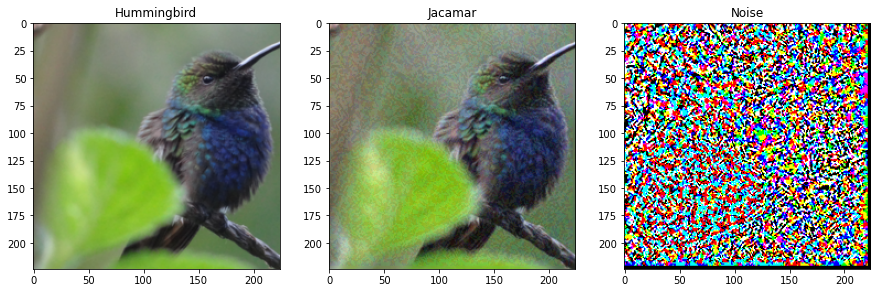

In [49]:
# {650: 'bee', 231: 'zebra', 834: 'white shark', 891: 'hummingbird', 535: 'panda'}
i = 891
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)

### PGD (Inception v3)

In [50]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/inception_v3/PGD_aggressive.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(black_box, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:05<00:00, 185.27it/s]

Accuracy@1: 59.4
Accuracy@5: 82.89999999999999


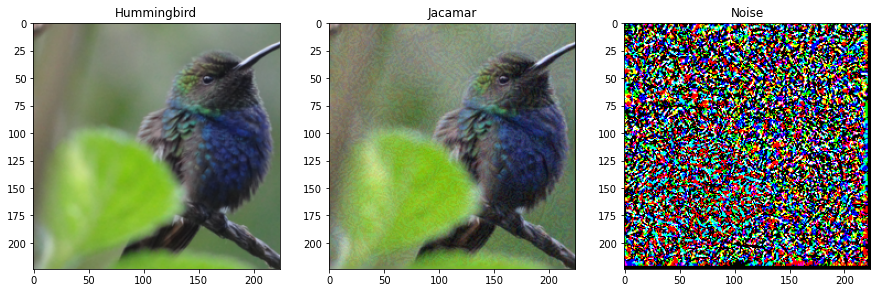

In [51]:
# {650: 'bee', 231: 'zebra', 834: 'white shark', 891: 'hummingbird', 535: 'panda'}
i = 891
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)

### MIFGSM (Inception v3)

In [52]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/inception_v3/MIFGSM_aggressive.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(black_box, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:05<00:00, 181.44it/s]

Accuracy@1: 56.3
Accuracy@5: 81.5


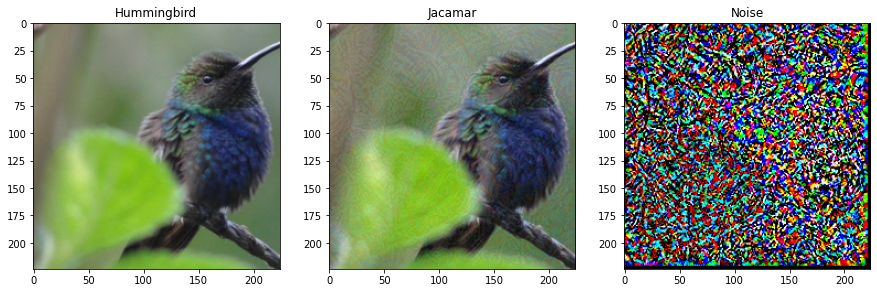

In [53]:
# {650: 'bee', 231: 'zebra', 834: 'white shark', 891: 'hummingbird', 535: 'panda'}
i = 891
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)

### OnePixel

In [20]:
# The adversarial images are in [0,1], so NormalizationLayer prepares them for the pre-trained model 
adv_images, adv_labels = torch.load('models/inception_v3/OnePixel_aggressive.pt')
adv_dataset = TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=None, shuffle=False, num_workers=4)

y_true_adv, y_pred_adv, accuracy_1, accuracy_5 = get_topk_accuracy(black_box, adv_loader)
print(f'Accuracy@1: {accuracy_1}')
print(f'Accuracy@5: {accuracy_5}')

100%|██████████| 1000/1000 [00:05<00:00, 185.96it/s]

Accuracy@1: 83.5
Accuracy@5: 97.0


Truth: cinema, movie theater, movie theatre, movie house, picture palace


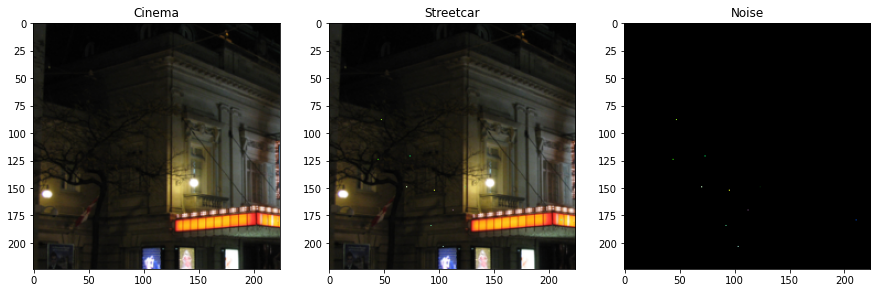

In [28]:
different_predictions = get_different_predictions(y_pred, y_pred_adv)
i = different_predictions[22]

print(f'Truth: {my_dataset.idx_to_class[y_true[i]]}')
plot_adversarial(my_dataset, adv_dataset, y_pred, y_pred_adv, i)